a).

Simulate the model and determine the flux control coefficients for each of the enzymes in the pathway

In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
# Define parameters from Figure 5.10
parameters = {
    'Met': 48.5,  # µM
    'V_MATI_max': 561,  # µM/hr
    'V_MATIII_max': 22870,  # µM/hr
    'V_GNMT_max': 10600,  # µM/hr
    'V_MET_max': 4544,  # µM/hr
    'alpha_d': 1333,  # hr^-1
    'K_AHC': 0.1,  
    'adenosine': 1,  # µM
    'K_MATI_m': 41,  # µM
    'K_MATI_i': 50,  # µM
    'K_MATIII_m2': 21.1,  # µM
    'K_GNMT_m': 4500,  # µM
    'K_GNMT_i': 20,  # µM
    'K_MET_m2_div_A': 10  # Dimensionless
}

In [3]:
# Define the differential equations for the pathway
def methionine_metabolism(y, t, params):
    AdoMet, AdoHcy = y

    # MATI reaction rate
    V_MATI = params['V_MATI_max'] / (
        1 + params['K_MATI_m'] / params['Met'] * (1 + AdoMet / params['K_MATI_i'])
    )

    # MATIII reaction rate (allosteric regulation)
    K_MATIII_m1 = 20000 / (1 + 5.7 * (AdoMet / (AdoMet + 600)) ** 2)
    V_MATIII = params['V_MATIII_max'] / (
        1 + (K_MATIII_m1 * params['K_MATIII_m2']) / (params['Met'] ** 2 + params['Met'] * params['K_MATIII_m2'])
    )

    # GNMT reaction rate
    V_GNMT = (
        params['V_GNMT_max'] / (1 + (params['K_GNMT_m'] / AdoMet) ** 2.3)
    ) * (1 / (1 + AdoHcy / params['K_GNMT_i']))

    # MET reaction rate
    K_MAT_m1 = 10 * (1 + AdoHcy / 4)
    V_MET = params['V_MET_max'] / (
        1 + K_MAT_m1 / AdoMet + params['K_MET_m2_div_A'] + (params['K_MET_m2_div_A'] * K_MAT_m1 / AdoMet)
    )

    # Homocysteine consumption (D)
    V_D = params['alpha_d'] * AdoHcy * params['K_AHC'] / params['adenosine']

    # Differential equations
    dAdoMet_dt = V_MATI + V_MATIII - V_GNMT - V_MET
    dAdoHcy_dt = 1 / (1 + params['K_AHC'] / params['adenosine']) * (V_GNMT + V_MET - V_D)

    return [dAdoMet_dt, dAdoHcy_dt]

In [4]:
# Initial concentrations from Figure 5.10
initial_concentrations = {
    'AdoMet': 10,  # µM
    'AdoHcy': 10,  # µM
}

In [5]:
# Time points for simulation
time_points = np.linspace(0, 100, 100000)  # simulate for 100 hours

In [6]:
def model_simulation(parameters, initial_concentrations, time):
    y0 = [initial_concentrations['AdoMet'], initial_concentrations['AdoHcy']]
    results = odeint(methionine_metabolism, y0, time, args=(parameters,))
    return results

In [7]:
results = model_simulation(parameters, initial_concentrations, time_points)
# Extract results
AdoMet_conc = results[:, 0]
AdoHcy_conc = results[:, 1]

In [8]:
# Store results for further analysis
steady_state_AdoMet = AdoMet_conc[-1]
steady_state_AdoHcy = AdoHcy_conc[-1]

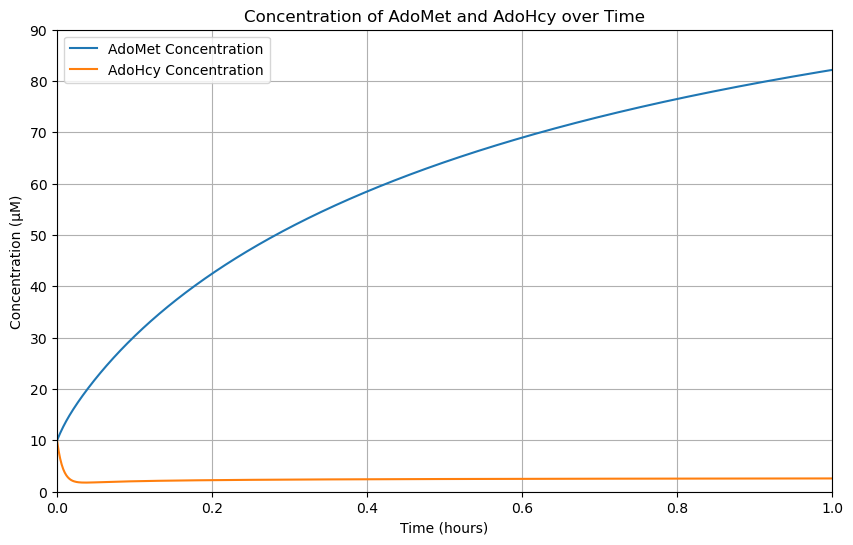

In [9]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, AdoMet_conc, label='AdoMet Concentration')
plt.plot(time_points, AdoHcy_conc, label='AdoHcy Concentration')
plt.xlim(0, 1)
plt.ylim(0, 90)
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Define flux equations for each enzyme at steady state
def calculate_fluxes(params, AdoMet, AdoHcy):
    # MATI reaction rate
    V_MATI = params['V_MATI_max'] / (
        1 + params['K_MATI_m'] / params['Met'] * (1 + AdoMet / params['K_MATI_i'])
    )

    # MATIII reaction rate (allosteric regulation)
    K_MATIII_m1 = 20000 / (1 + 5.7 * (AdoMet / (AdoMet + 600)) ** 2)
    V_MATIII = params['V_MATIII_max'] / (
        1 + (K_MATIII_m1 * params['K_MATIII_m2']) / (params['Met'] ** 2 + params['Met'] * params['K_MATIII_m2'])
    )

    # GNMT reaction rate
    V_GNMT = (
        params['V_GNMT_max'] / (1 + (params['K_GNMT_m'] / AdoMet) ** 2.3)
    ) * (1 / (1 + AdoHcy / params['K_GNMT_i']))

    # MET reaction rate
    K_MAT_m1 = 10 * (1 + AdoHcy / 4)
    V_MET = params['V_MET_max'] / (
        1 + K_MAT_m1 / AdoMet + params['K_MET_m2_div_A'] + (params['K_MET_m2_div_A'] * K_MAT_m1 / AdoMet)
    )

    # Homocysteine consumption (D)
    V_D = params['alpha_d'] * AdoHcy * params['K_AHC'] / params['adenosine']
    return V_MATI, V_MATIII, V_GNMT, V_MET, V_D

In [11]:
# Calculate fluxes at steady state
steady_fluxes = calculate_fluxes(parameters, steady_state_AdoMet, steady_state_AdoHcy)

In [138]:
steady_fluxes

(153.92661485222126,
 204.75255011587674,
 1.6988465456307926,
 356.9803184224689,
 358.6791649680998)

In [12]:
steady_fluxes[0] + steady_fluxes[1], steady_fluxes[2] + steady_fluxes[3], steady_fluxes[4]

(358.679164968098, 358.67916496809966, 358.6791649680998)

In [135]:
# Define control coefficient calculation function
def flux_control_coefficients(params, original_pathway_flux, AdoMet, AdoHcy):
    
    control_coefficients = []

    # Partial derivatives approximated by small perturbations
    perturbation = 0.05

    # perturbed_fluxes = {
    #     enzyme: calculate_fluxes({**params, enzyme: params[enzyme] * (1 + perturbation)}, AdoMet, AdoHcy)
    #     for enzyme in ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max', 'alpha_d']
    # }

    enzymes = ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max']
    # enzymes = ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max', 'alpha_d']

    for i in range(len(enzymes)):
        simulation_results = model_simulation({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, initial_concentrations, time_points)
        AdoMet_ss = simulation_results[-1, 0]
        AdoHcy_ss = simulation_results[-1, 1]
        perturbed_fluxes = calculate_fluxes({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, AdoMet_ss, AdoHcy_ss)
        print(perturbed_fluxes[0]+perturbed_fluxes[1], perturbed_fluxes[2]+perturbed_fluxes[3], perturbed_fluxes[4])
        print(original_pathway_flux)

        perturbed_pathway_flux = perturbed_fluxes[0] + perturbed_fluxes[1] 
        coeff = (perturbed_pathway_flux - original_pathway_flux) * (params[enzymes[i]] / (original_pathway_flux * perturbation * params[enzymes[i]]))
        control_coefficients.append(coeff)


    # Calculate flux control coefficients
    # control_coefficients = {
    #     enzyme: ((perturbed_fluxes[enzyme][0] - V_MATI) / (V_MATI * perturbation))
    #     for enzyme in perturbed_fluxes
    # }

    # control_coefficients = {}
    # for ind in range(len(enzymes)):
    #     enzyme = list(perturbed_pathway_flux.keys())[ind]
    #     control_coefficients[enzyme] = (perturbed_pathway_flux[enzyme] - original_pathway_flux) / (params[enzyme] / (original_pathway_flux * perturbation * params[enzyme]))
    
    return control_coefficients

In [136]:
# Calculate the flux control coefficients
original_pathway_flux = steady_fluxes[-1]
flux_control_coeffs = flux_control_coefficients(parameters, original_pathway_flux, steady_state_AdoMet, steady_state_AdoHcy)

363.0309201634697 363.0309201636127 363.0309201636132
358.6791649680998
364.99190167898564 364.99190168468135 364.9919016846997
358.6791649680998
358.7132131466277 358.7132131466207 358.7132131466207
358.6791649680998
365.9361470857377 365.9361470856323 365.9361470856317
358.6791649680998


In [137]:
print(flux_control_coeffs, sum(flux_control_coeffs))

[0.242654473434883, 0.35199907479695713, 0.001898531158391134, 0.4046503296774022] 1.0012024090676335


should i include the coeff on a_d, if not the sum doesnt add up exactly to 1. 
played with the perterbed distance, the sum is changing arond 1? 

(b). 

In [141]:
parameters

{'Met': 48.5,
 'V_MATI_max': 561,
 'V_MATIII_max': 22870,
 'V_GNMT_max': 10600,
 'V_MET_max': 4544,
 'alpha_d': 1333,
 'K_AHC': 0.1,
 'adenosine': 1,
 'K_MATI_m': 41,
 'K_MATI_i': 50,
 'K_MATIII_m2': 21.1,
 'K_GNMT_m': 4500,
 'K_GNMT_i': 20,
 'K_MET_m2_div_A': 10}

In [140]:
{**parameters, 'Met': 51}

{'Met': 51,
 'V_MATI_max': 561,
 'V_MATIII_max': 22870,
 'V_GNMT_max': 10600,
 'V_MET_max': 4544,
 'alpha_d': 1333,
 'K_AHC': 0.1,
 'adenosine': 1,
 'K_MATI_m': 41,
 'K_MATI_i': 50,
 'K_MATIII_m2': 21.1,
 'K_GNMT_m': 4500,
 'K_GNMT_i': 20,
 'K_MET_m2_div_A': 10}

In [144]:
simulation_results_b = model_simulation({**parameters, 'Met': 51}, initial_concentrations, time_points)
AdoMet_ss_b = simulation_results_b[-1, 0]
AdoHcy_ss_b = simulation_results_b[-1, 1]
fluxes_b = calculate_fluxes({**parameters, 'Met': 51}, AdoMet_ss_b, AdoHcy_ss_b)
print(fluxes_b[0]+fluxes_b[1], fluxes_b[2]+fluxes_b[3], fluxes_b[4])

375.1521115035074 375.1521115158019 375.15211151583185


In [146]:
steady_fluxes

(153.92661485222126,
 204.75255011587674,
 1.6988465456307926,
 356.9803184224689,
 358.6791649680998)

In [145]:
fluxes_b

(132.29987183502803,
 242.85223966847937,
 3.8083859532445516,
 371.3437255625573,
 375.15211151583185)

In [153]:
np.array(list(fluxes_b)) - np.array(list(steady_fluxes))

array([-21.62674302,  38.09968955,   2.10953941,  14.36340714,
        16.47294655])

this doesnt align with the question statement, MATIII and GNMT should have a dramatic increase, and MET have a relatively small increase. 

(c). 

In [154]:
params_c = {**parameters, 'Met': 51}
params_c

{'Met': 51,
 'V_MATI_max': 561,
 'V_MATIII_max': 22870,
 'V_GNMT_max': 10600,
 'V_MET_max': 4544,
 'alpha_d': 1333,
 'K_AHC': 0.1,
 'adenosine': 1,
 'K_MATI_m': 41,
 'K_MATI_i': 50,
 'K_MATIII_m2': 21.1,
 'K_GNMT_m': 4500,
 'K_GNMT_i': 20,
 'K_MET_m2_div_A': 10}

In [179]:
initial_concentrations_c = {
    'AdoMet': 400,  # µM
    'AdoHcy': 2,  # µM
}

In [180]:
simulation_results_c = model_simulation(params_c, initial_concentrations_c, time_points)
AdoMet_ss_c = simulation_results_c[-1, 0]
AdoHcy_ss_c = simulation_results_c[-1, 1]

In [181]:
simulation_results_c

array([[400.        ,   2.        ],
       [400.00834067,   2.14379646],
       [400.01722897,   2.2707164 ],
       ...,
       [975.1016532 ,   4.87293448],
       [975.1016532 ,   4.87293448],
       [975.1016532 ,   4.87293448]])

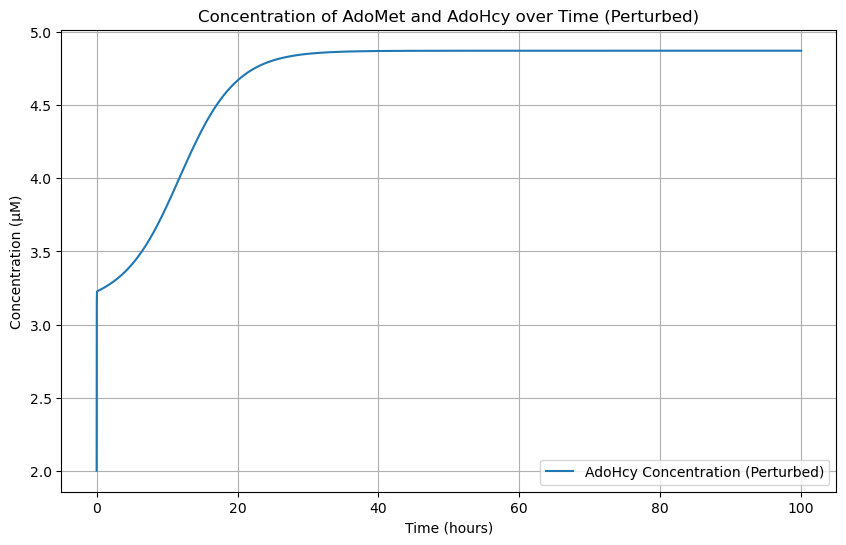

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(time_points, simulation_results_c[:, 0], label='AdoMet Concentration (Perturbed)')
plt.plot(time_points, simulation_results_c[:, 1], label='AdoHcy Concentration (Perturbed)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time (Perturbed)')
plt.legend()
plt.grid(True)
plt.show()

In [189]:
simulation_results_c_perturbed = model_simulation({**params_c, 'V_MATIII_max': parameters['V_MATIII_max']*1.1}, initial_concentrations_c, time_points)
simulation_results_c_perturbed

array([[ 400.        ,    2.        ],
       [ 400.04582259,    2.14380048],
       [ 400.09220089,    2.27073182],
       ...,
       [1196.43263704,    5.82909493],
       [1196.43263704,    5.82909493],
       [1196.43263704,    5.82909493]])

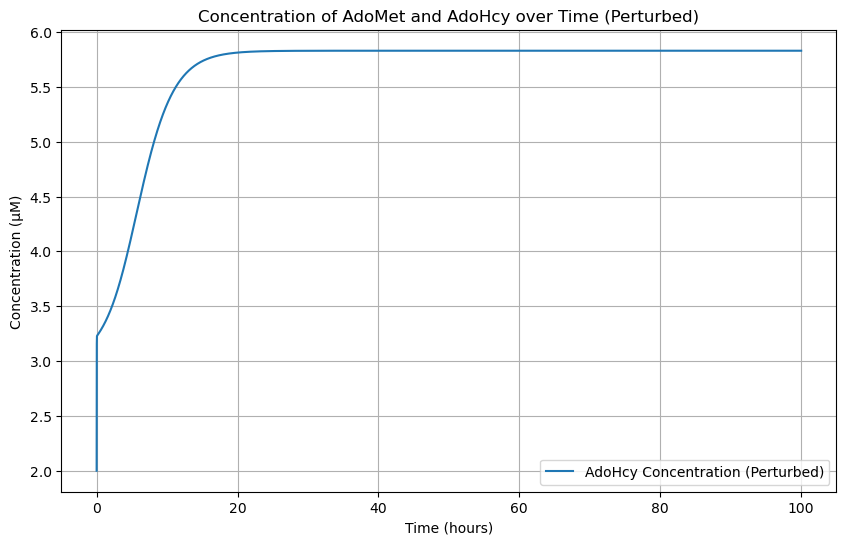

In [191]:
plt.figure(figsize=(10, 6))
# plt.plot(time_points, simulation_results_c_perturbed[:, 0], label='AdoMet Concentration (Perturbed)')
plt.plot(time_points, simulation_results_c_perturbed[:, 1], label='AdoHcy Concentration (Perturbed)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time (Perturbed)')
plt.legend()
plt.grid(True)
plt.show()

chose i.c. between the stable and unstable fixed point, goes to the stable f.p. on the left, but when perturbed more than 15 % still goes to the same fixed point